In [1]:
import atoti as tt

Welcome to Atoti 0.8.10!

By using this community edition, you agree with the license available at https://docs.atoti.io/latest/eula.html.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

Atoti collects telemetry data, which is used to help understand how to improve the product.
If you don't wish to send usage data, you can request a trial license at https://www.atoti.io/evaluation-license-request.

You can hide this message by setting the `ATOTI_HIDE_EULA_MESSAGE` environment variable to True.


In [2]:
session = tt.Session(                            #Creare atoti session
    user_content_storage=".content",
    port=9095,
    java_options=["-Xms1G", "-Xmx10G"]
)

In [3]:
db_name = "Project1"
db_user = "postgres"
db_password = "postgres"  
db_host = "localhost"  
db_port = "5432"

In [4]:
jdbc_url = f"jdbc:postgresql://{db_host}:{db_port}/{db_name}?user={db_user}&password={db_password}" #Create URL

In [5]:
jdbc_url

'jdbc:postgresql://localhost:5432/Project1?user=postgres&password=postgres'

In [6]:
fact_olympic = session.read_sql(       #Get main fact table
    "SELECT * FROM factolympic",
    keys=["year","country"],
    table_name="Olympic",
    url=jdbc_url,
)

In [7]:
dim_countries = session.read_sql(     #Get countries facttable
    "SELECT * FROM dimcountries",
    keys=["country"],
    table_name="Countries",
    url=jdbc_url)

In [8]:
dim_life = session.read_sql( #Get life expectancy dimension table
    "SELECT * FROM dimlife",
    keys=["year","country"],
    table_name="Life",
    url=jdbc_url)

In [9]:
dim_time = session.read_sql(  #Get time dimension table
    "SELECT * FROM dimtime",
    keys=["year"],
    table_name="Time",
    url=jdbc_url)

In [10]:
fact_olympic.join(dim_countries, fact_olympic["country"] == dim_countries["country"])  #Join tables based 

In [11]:
fact_olympic.join(dim_life, (fact_olympic["year"] == dim_life["year"] )& (fact_olympic["country"] == dim_life["country"]))

In [12]:
fact_olympic.join(dim_time, fact_olympic["year"] == dim_time["year"])

In [13]:
session.tables.schema

```mermaid
erDiagram
  "Countries" {
    _ String PK "country"
    _ String "continent"
  }
  "Life" {
    _ int PK "year"
    _ String PK "country"
    _ String "lifeexpectancy"
    _ String "population"
  }
  "Time" {
    _ int PK "year"
    _ String "decade"
    _ String "season"
  }
  "Olympic" {
    _ int PK "year"
    _ String PK "country"
    nullable int "bronze"
    nullable int "silver"
    nullable int "gold"
    nullable int "total"
    nullable double "depression"
    nullable double "schizophrenia"
    nullable double "bipolar"
    nullable double "eatingdisorder"
    nullable double "anxiety"
  }
  "Olympic" }o--o| "Countries" : "`country` == `country`"
  "Olympic" }o--o| "Life" : "(`year` == `year`) & (`country` == `country`)"
  "Olympic" }o--o| "Time" : "`year` == `year`"
```


In [14]:
fact_olympic.head()

bronze  silver  gold  total  depression  schizophrenia  \
year country                                                               
2018 China             2       7     1     10    419.2856      202.93486   
     Pakistan          0       0     0      0   662.26276      177.39119   
     Brazil            0       0     0      0     685.841      176.80495   
     South Korea       4       8     5     17   359.07388      194.25919   
     Iraq              0       0     0      0   693.02216      156.16316   

                     bipolar  eatingdisorder    anxiety  
year country                                             
2018 China         39.638176       24.338549  310.26324  
     Pakistan       83.03932       25.683395  327.31042  
     Brazil        239.34134        49.10756   701.5429  
     South Korea  108.985725        74.87254  311.52283  
     Iraq           145.3553        43.88158  508.72513

In [15]:
testcube = session.create_cube(fact_olympic)  #Cube creation

In [16]:
testcube

In [17]:
hierarchies, levels, measures = testcube.hierarchies, testcube.levels, testcube.measures

In [18]:
hierarchies["Countries","continent"] = [dim_countries["continent"],dim_countries["country"]]
hierarchies["Time","time"] = [dim_time["decade"],dim_time["year"],dim_time['season']]
hierarchies["Lifexpectancy","lifeexpectancy"] = [dim_life["lifeexpectancy"],dim_life['population']]

In [19]:
del hierarchies["Olympic","country"]
del hierarchies["Olympic","year"]
del hierarchies["Time","decade"]
del hierarchies['Time','season']

In [20]:
del hierarchies['Life', 'population']
del hierarchies ['Life', 'lifeexpectancy']

In [23]:
list(levels)

[('Countries', 'continent', 'continent'),
 ('Countries', 'continent', 'country'),
 ('Time', 'time', 'decade'),
 ('Time', 'time', 'year'),
 ('Time', 'time', 'season'),
 ('Lifexpectancy', 'lifeexpectancy', 'lifeexpectancy'),
 ('Lifexpectancy', 'lifeexpectancy', 'population')]

In [24]:
measures

{'contributors.COUNT': <atoti.measure.Measure object at 0x7a31a4cb0340>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x7a31583204c0>, 'depression.MEAN': <atoti.measure.Measure object at 0x7a31583204f0>, 'depression.SUM': <atoti.measure.Measure object at 0x7a3158320520>, 'bipolar.MEAN': <atoti.measure.Measure object at 0x7a3158320550>, 'bipolar.SUM': <atoti.measure.Measure object at 0x7a3158320580>, 'bronze.MEAN': <atoti.measure.Measure object at 0x7a31583205b0>, 'bronze.SUM': <atoti.measure.Measure object at 0x7a3158320100>, 'total.MEAN': <atoti.measure.Measure object at 0x7a31583200d0>, 'total.SUM': <atoti.measure.Measure object at 0x7a31583205e0>, 'anxiety.MEAN': <atoti.measure.Measure object at 0x7a3158320250>, 'anxiety.SUM': <atoti.measure.Measure object at 0x7a3158320220>, 'silver.MEAN': <atoti.measure.Measure object at 0x7a3158320070>, 'silver.SUM': <atoti.measure.Measure object at 0x7a3158320040>, 'gold.MEAN': <atoti.measure.Measure object at 0x7a3158320610>, 'gold.SUM': <atoti.measure.Measure object at 0x7a3158320640>, 'schizophrenia.MEAN': <atoti.measure.Measure object at 0x7a3158320670>, 'schizophrenia.SUM': <atoti.measure.Measure object at 0x7a31583206a0>, 'eatingdisorder.MEAN': <atoti.measure.Measure object at 0x7a31583206d0>, 'eatingdisorder.SUM': <atoti.measure.Measure object at 0x7a3158320700>}

In [25]:
testcube.query(measures["depression.SUM"],measures["anxiety.SUM"],measures["total.SUM"], levels=[levels[('Countries', 'continent', 'continent')]])  #Query 1 

,depression.SUM,anxiety.SUM,total.SUM
continent,,,
Africa,"571,722.66","246,325.63",257
Asia,"399,496.68","234,930.53","1,675"
Europe,"358,599.07","265,029.54","4,596"
North America,"233,874.03","152,696.12","1,601"
Oceania,"131,911.80","107,294.79",434
South America,"103,600.52","83,490.35",194


In [26]:
testcube.query(measures["depression.SUM"],measures["anxiety.SUM"], levels=[levels[('Countries', 'continent', 'country')]])  #Query 2 

depression.SUM anxiety.SUM
continent     country                                
Africa        Algeria           10,308.49    6,286.71
              Angola            14,912.28    5,275.23
              Benin             10,685.91    4,250.11
              Botswana          10,196.28    4,666.90
              Burkina Faso      10,513.99    4,118.61
...                                   ...         ...
South America Paraguay           8,941.41    8,244.87
              Peru               5,184.33    7,363.38
              Suriname          12,109.18    5,465.78
              Uruguay            6,680.56    6,810.08
              Venezuela          7,929.14    5,144.00

[198 rows x 2 columns]

In [27]:
testcube.query(measures["depression.SUM"],measures["anxiety.SUM"],measures["total.SUM"], levels=[levels[('Time', 'time', 'decade')],levels[('Countries', 'continent', 'country')]])  #Query 3 

depression.SUM anxiety.SUM total.SUM
decade      continent     country                                          
1990 - 1999 Africa        Algeria            3,005.46    1,782.47         5
                          Angola             4,348.27    1,500.46         0
                          Benin              3,001.63    1,204.30         0
                          Botswana           2,894.22    1,328.67         0
                          Burkina Faso       2,926.88    1,164.91         0
...                                               ...         ...       ...
2010 - 2019 South America Paraguay           3,286.82    2,969.81         0
                          Peru               1,749.46    2,654.49         0
                          Suriname           4,391.26    1,962.49         0
                          Uruguay            2,522.32    2,453.04         0
                          Venezuela          2,823.48    1,878.37         4

[594 rows x 3 columns]

In [28]:
testcube.query(measures["depression.SUM"],measures["anxiety.SUM"],measures["total.SUM"], levels=[levels[('Time', 'time', 'season')],levels[('Countries', 'continent', 'country')]])  #Query 4 

depression.SUM anxiety.SUM  \
decade      year season continent     country                                   
1990 - 1999 1992 Winter Africa        Algeria              756.25      445.17   
                                      Angola             1,089.69      374.59   
                                      Benin                747.03      300.62   
                                      Botswana             713.80      333.07   
                                      Burkina Faso         745.73      291.58   
...                                                           ...         ...   
2010 - 2019 2018 Winter South America Paraguay             666.39      600.26   
                                      Peru                 353.82      532.50   
                                      Suriname             876.10      393.15   
                                      Uruguay              511.06      493.17   
                                      Venezuela            567.80      383.30   

                                                   total.SUM  
decade      year season continent     country                 
1990 - 1999 1992 Winter Africa        Algeria              2  
                                      Angola               0  
                                      Benin                0  
                                      Botswana             0  
                                      Burkina Faso         0  
...                                                      ...  
2010 - 2019 2018 Winter South America Paraguay             0  
                                      Peru                 0  
                                      Suriname             0  
                                      Uruguay              0  
                                      Venezuela            0  

[2772 rows x 3 columns]

In [29]:
testcube.query(measures["depression.SUM"],measures["anxiety.SUM"],measures["total.SUM"], levels=[levels['Lifexpectancy', 'lifeexpectancy', 'lifeexpectancy'],levels[('Countries', 'continent', 'continent')]])  #Query 5 

depression.SUM anxiety.SUM total.SUM
lifeexpectancy continent                                         
High           Africa             52,905.85   30,984.46        30
               Asia              180,041.60  111,390.99       466
               Europe            299,912.95  228,999.62     3,702
               North America     141,426.98   97,865.71     1,415
               Oceania            28,395.34   24,067.79       432
               South America      62,368.06   56,531.63       153
Low            Africa            273,366.16  109,226.52        91
               Asia                8,999.52    5,180.93         0
               Europe                552.26      338.92         0
               North America       3,261.74    2,105.08         0
Medium         Africa            199,301.27   87,116.66       136
               Asia              142,469.45   73,829.12       181
               Europe             28,436.31   14,731.82       261
               North America      38,330.98   23,537.58         4
               Oceania            64,233.71   51,342.37         2
               South America      41,232.47   26,958.72        41
N/A            Africa             46,149.38   18,997.99         0
               Asia               67,986.12   44,529.50     1,028
               Europe             29,697.56   20,959.18       633
               North America      50,854.32   29,187.75       182
               Oceania            39,282.75   31,884.62         0

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
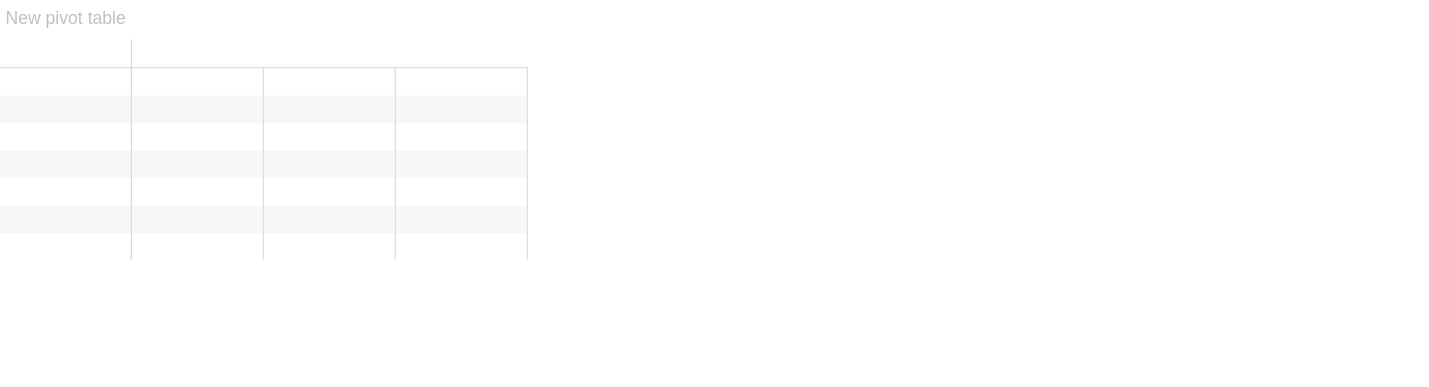

In [30]:
session.widget